Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Перенесем код из методички

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Функция,суммирующая предсказания базовых алгорритмов

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [9]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

Модель с 10-ю деревьями глубиной 1

In [24]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 1 на тренировочной выборке: 2517.125531636622
Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 1 на тестовой выборке: 4182.37529850902



Построим графики зависимости ошибки на обучающей и тестовой выборках от числа и глубины деревьев

In [20]:
import matplotlib.pyplot as plt

In [21]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

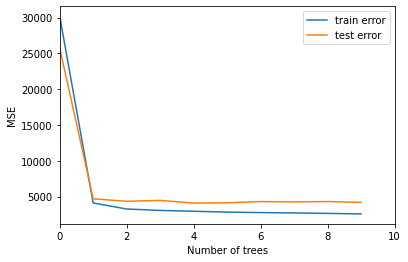

In [26]:
get_error_plot(n_trees, train_errors, test_errors)

Изменим глубину дерева до 3

In [29]:
# Максимальная глубина деревьев
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [30]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1040.9108127122834
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4796.566788544516


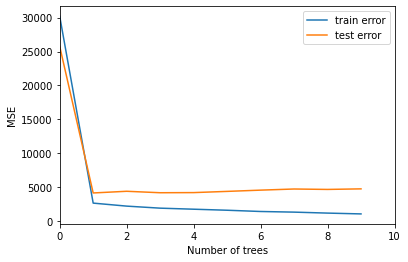

In [32]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличение глубины привело к уменьшению ошибки на обучающей выборке, но увеличило ошибку на тестовой выборке. В результате наблюдаем значительное переобучение   

Увеличим глубину до 5

In [33]:
# Максимальная глубина деревьев
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [34]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 139.97581910560993
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 1 на тестовой выборке: 6541.767077458205


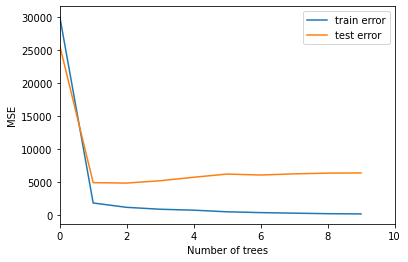

In [35]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличение глубины привело к уменьшению ошибки на обучающей выборке, но увеличило ошибку на тестовой выборке. В результате наблюдаем значительное переобучение

Увеличим число деревьев до 25 с глубиной 1

In [36]:
# Число деревьев в ансамбле
n_trees = 25

# Максимальная глубина деревьев
max_depth = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [37]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 1     с шагом 1 на тренировочной выборке: 2517.125531636622
Ошибка алгоритма из 25 деревьев глубиной 1     с шагом 1 на тестовой выборке: 4182.37529850902


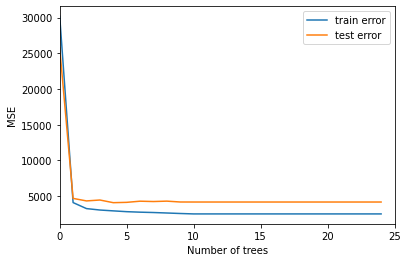

In [38]:
get_error_plot(n_trees, train_errors, test_errors)

Ошибка та же,что и при 10-ти деревьях глубиной 1

Увеличим глубину до 3

In [39]:
# Максимальная глубина деревьев
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [40]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1040.9108127122834
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4796.566788544516


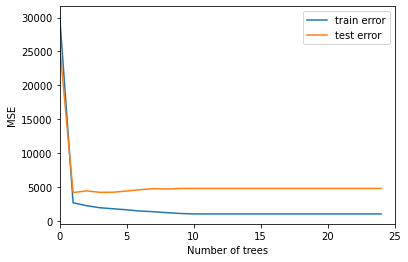

In [41]:
get_error_plot(n_trees, train_errors, test_errors)

Ошибка и переобучение примерно те же,что и при 10-ти деревьях глубиной 3

Увеличим глубину до 5

In [42]:
# Максимальная глубина деревьев
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [43]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 139.97581910560993
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 1 на тестовой выборке: 6541.767077458205


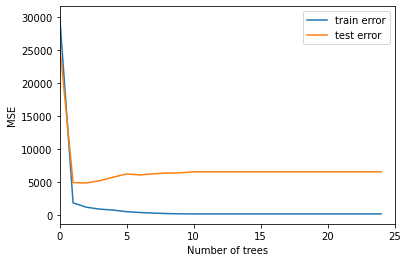

In [44]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличение количества деревьев ни на чо не влияет,в какой-то момент ошибка выходит на плато. Увеличение глубины деревьев ведет к переобучению.

Увеличим число деревьев до 100 с глубиной 1

In [45]:
# Число деревьев в ансамбле
n_trees = 100

# Максимальная глубина деревьев
max_depth = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [46]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 1     с шагом 1 на тренировочной выборке: 2517.125531636622
Ошибка алгоритма из 100 деревьев глубиной 1     с шагом 1 на тестовой выборке: 4182.37529850902


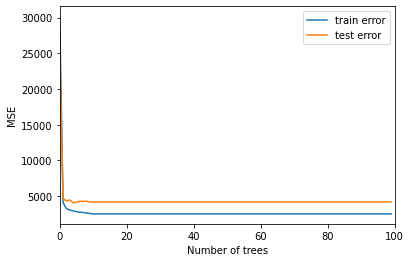

In [47]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличим глубину до 3

In [48]:
# Максимальная глубина деревьев
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [49]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1040.9108127122834
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4796.566788544516


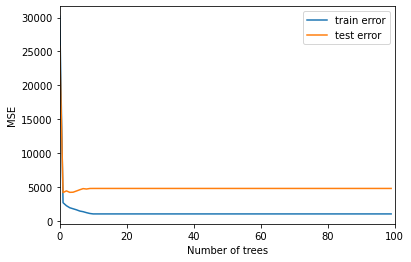

In [50]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличим глубину до 5

In [51]:
# Максимальная глубина деревьев
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [52]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 139.97581910560993
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 1 на тестовой выборке: 6541.767077458205


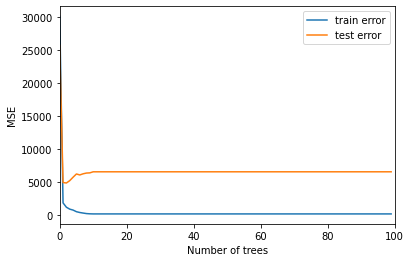

In [53]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличение количества деревьев ни на чо не влияет,в какой-то момент ошибка выходит на плато. Увеличение глубины деревьев ведет к переобучению.

На опциональные задания, к сожалению, нет времени